# Import Libraries

In [64]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Download necessary libraries

In [2]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('vader_lexicon')

## Read Data

In [3]:
train_df = pd.read_csv("../data/Twitter/twitter_training.csv",header=None)
test_df = pd.read_csv("../data/Twitter/twitter_validation.csv",header=None)
train_df.columns = ['number','topic','sentiment','tweet']
test_df.columns = ['number','topic','sentiment','tweet']

In [4]:
train_df.head()

,number,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
test_df.head()

,number,topic,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## Short Data Summary

In [6]:
train_df.shape, test_df.shape

((74682, 4), (1000, 4))

In [7]:
train_df.sentiment.unique(), test_df.sentiment.unique()

(array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object),
 array(['Irrelevant', 'Neutral', 'Negative', 'Positive'], dtype=object))

In [8]:
train_df.groupby("sentiment").count()

,number,topic,tweet
sentiment,,,
Irrelevant,12990,12990,12875
Negative,22542,22542,22358
Neutral,18318,18318,18108
Positive,20832,20832,20655


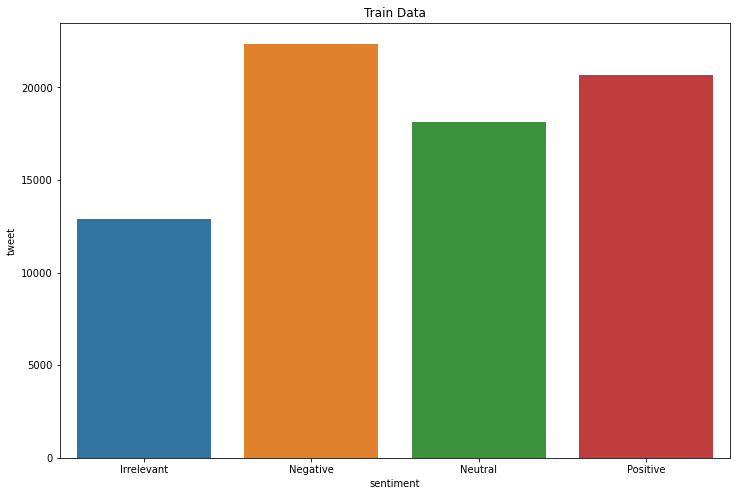

In [9]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(data=train_df.groupby('sentiment').count().reset_index(), x='sentiment', y='tweet',ax = ax)
plt.title("Train Data")
plt.show()
plt.close()

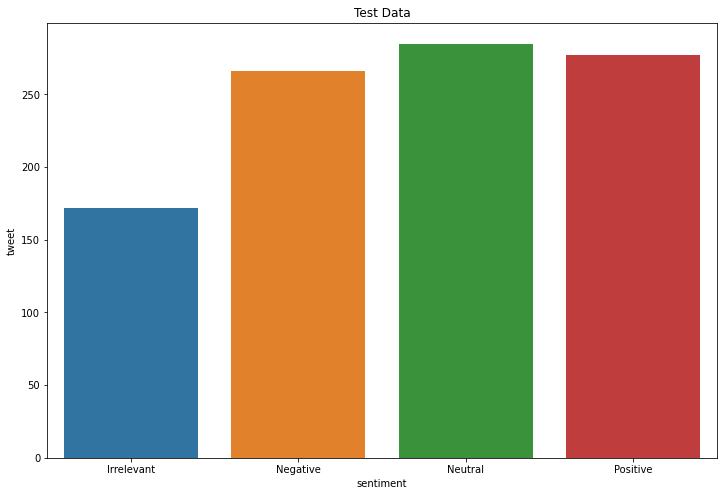

In [10]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(data=test_df.groupby('sentiment').count().reset_index(), x='sentiment', y='tweet',ax = ax)
plt.title("Test Data")
plt.show()
plt.close()

### Data Preprocessing - encode sentiment // keep only sentiment &tweet

In [11]:
train_df.head()

,number,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [12]:
test_df.head()

,number,topic,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [13]:
train_df.groupby('sentiment').count()

,number,topic,tweet
sentiment,,,
Irrelevant,12990,12990,12875
Negative,22542,22542,22358
Neutral,18318,18318,18108
Positive,20832,20832,20655


In [14]:
test_df.groupby('sentiment').count()

,number,topic,tweet
sentiment,,,
Irrelevant,172,172,172
Negative,266,266,266
Neutral,285,285,285
Positive,277,277,277


In [15]:
def process_sentiment(df):
    df = df[df['sentiment'].isin(['Positive','Negative','Neutral'])]
    df.loc[df.sentiment=='Positive', 'sentiment'] = 2
    df.loc[df.sentiment=='Neutral', 'sentiment'] = 1
    df.loc[df.sentiment=='Negative', 'sentiment'] = 0
    df['sentiment'] = df['sentiment'].astype(int)
    #df.drop(['number','topic'],axis=1,inplace=True)
    return df[['tweet','sentiment']]

In [16]:
train_df = process_sentiment(train_df)
test_df = process_sentiment(test_df)

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/f7/frkz7fzd1hd5r3hc24670dnm0000gn/T/ipykernel_32653/3760496259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].astype(int)


In [17]:
train_df['sentiment'].unique(), test_df['sentiment'].unique()

(array([2, 1, 0]), array([1, 0, 2]))

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61692 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      61121 non-null  object
 1   sentiment  61692 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 1 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      828 non-null    object
 1   sentiment  828 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 19.4+ KB


# Tweet Processing

In [20]:
# use pipeline

In [21]:
# define stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [22]:
def text_process(text):
    text = re.sub("[^a-zA-Z]"," ",str(text))
    # convert to lower case
    text = text.lower().split()
    text = [lemmatizer.lemmatize(str(x)) for x in text] #lemmatizing
    #text = [w for w in text if not w in stop_words]
    #text = " ".join(text)
    return text

In [23]:
train_df.head()

,tweet,sentiment
0,im getting on borderlands and i will murder yo...,2
1,I am coming to the borders and I will kill you...,2
2,im getting on borderlands and i will kill you ...,2
3,im coming on borderlands and i will murder you...,2
4,im getting on borderlands 2 and i will murder ...,2


In [24]:
train_df['tweet'] = [text_process(text) for text in train_df['tweet']]

In [25]:
test_df['tweet'] = [text_process(text) for text in test_df['tweet']]

In [26]:
train_df.head()

,tweet,sentiment
0,"[im, getting, on, borderland, and, i, will, mu...",2
1,"[i, am, coming, to, the, border, and, i, will,...",2
2,"[im, getting, on, borderland, and, i, will, ki...",2
3,"[im, coming, on, borderland, and, i, will, mur...",2
4,"[im, getting, on, borderland, and, i, will, mu...",2


In [27]:
test_df.head()

,tweet,sentiment
1,"[bbc, news, amazon, bos, jeff, bezos, reject, ...",1
2,"[microsoft, why, do, i, pay, for, word, when, ...",0
3,"[csgo, matchmaking, is, so, full, of, closet, ...",0
4,"[now, the, president, is, slapping, american, ...",1
5,"[hi, eahelp, i, ve, had, madeleine, mccann, in...",0


In [28]:
from tensorflow.keras.utils import to_categorical

target = train_df.sentiment.values
y_target = to_categorical(target)
y_test = to_categorical(test_df['sentiment'])

# number of numerical values exist in y_target's column
num_classes = y_target.shape[1]

In [29]:
print(num_classes)

3


# Train Test Split

In [31]:
X_train, X_val, y_train, y_val = train_test_split(train_df['tweet'],
                                                  y_target,
                                                  test_size = 0.2,
                                                  stratify = train_df['sentiment'])

In [32]:
X_test = test_df['tweet']
y_test = y_test

In [33]:
unique_words = set()
len_max = 0

for sent in (X_train):
    unique_words.update(sent)
    if(len_max < len(sent)):
        len_max = len(sent)

# length of the list of unique_words 
print('Number of vocabs: ', len(list(unique_words)))
print('Max length of text is: ', len_max)

Number of vocabs:  22212
Max length of text is:  149


In [34]:
vocab_size = len(list(unique_words))
embedding_dim = 300
max_length = len_max
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
tokenizer = Tokenizer(num_words = vocab_size,
                      # filters = '#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      oov_token = oov_tok,
                      # lower = True,
                      char_level = False)

tokenizer.fit_on_texts(list(X_train))

In [37]:
X_train.shape

(49353,)

In [38]:
# Training
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,
                        maxlen = max_length,
                        padding = padding_type,
                        truncating = trunc_type)

# Validation
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,
                      maxlen = max_length,
                      padding = padding_type,
                      truncating = trunc_type)

# Testing
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test,
                       maxlen = max_length,
                       padding = padding_type,
                       truncating = trunc_type)

In [39]:
X_train.shape

(49353, 149)

# Deep Network

In [78]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout, Embedding, LSTM,GRU, SpatialDropout1D,Bidirectional
from keras.models import Sequential

In [41]:
early_stopping = EarlyStopping(min_delta = 0.001,
                               mode = 'max',
                               monitor = 'val_acc',
                               patience = 2)
callback = [early_stopping]

In [42]:
max_length

149

In [43]:
model = Sequential()
model.add(Embedding(vocab_size,300,input_length = max_length))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(256, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)))
model.add(Bidirectional(LSTM(128,dropout = 0.5,recurrent_dropout=0.5,return_sequences=True)))
model.add(Bidirectional(GRU(128,return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(3,activation='softmax'))

2022-07-11 21:16:20.824619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
X_train.shape

(49353, 149)

In [45]:
y_train.shape

(49353, 3)

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 149, 300)          6663600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 149, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 149, 512)         1140736   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 149, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              296448    
 nal)                                                   

In [48]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
history=model.fit(X_train, y_train,batch_size=512, epochs=10,verbose=1,callbacks=callback,validation_split=0.1)

Epoch 1/10
87/87 [==============================] - 1184s 14s/step - loss: 0.9218 - accuracy: 0.5538 - val_loss: 0.7069 - val_accuracy: 0.7115
Epoch 2/10
87/87 [==============================] - 1465s 17s/step - loss: 0.6485 - accuracy: 0.7317 - val_loss: 0.5368 - val_accuracy: 0.7810
Epoch 3/10
87/87 [==============================] - 1608s 19s/step - loss: 0.4964 - accuracy: 0.8024 - val_loss: 0.4505 - val_accuracy: 0.8250
Epoch 4/10
87/87 [==============================] - 1741s 20s/step - loss: 0.4072 - accuracy: 0.8394 - val_loss: 0.3746 - val_accuracy: 0.8562
Epoch 5/10
87/87 [==============================] - 1754s 20s/step - loss: 0.3453 - accuracy: 0.8634 - val_loss: 0.3349 - val_accuracy: 0.8657
Epoch 6/10
87/87 [==============================] - 1558s 18s/step - loss: 0.3044 - accuracy: 0.8798 - val_loss: 0.3068 - val_accuracy: 0.8797
Epoch 7/10
87/87 [==============================] - 1371s 16s/step - loss: 0.2679 - accuracy: 0.8929 - val_loss: 0.2811 - val_accuracy: 0.8912

In [50]:
#model.save('Model.h5')

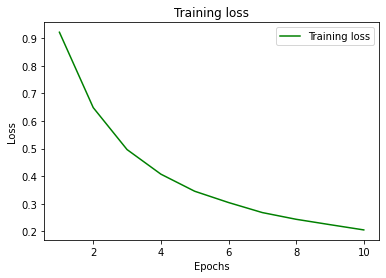

In [51]:
loss_train = history.history['loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


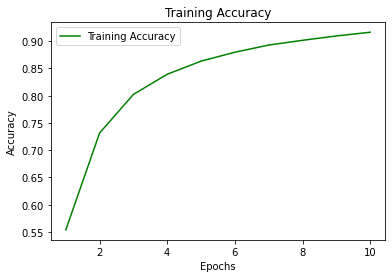

In [52]:
accuracy_train = history.history['accuracy']
epochs = range(1,11)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

26/26 [==============================] - 16s 411ms/step


# Evaluation

In [60]:
print("Accuracy Score: {}".format(accuracy_score(test_df.sentiment.values,classes_x)))

Accuracy Score: 0.9408212560386473


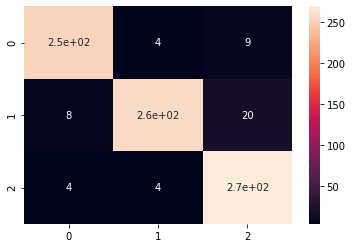

In [72]:
#Confusion Matrix
fig,ax = plt.subplots()
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1), classes_x),annot=True,ax=ax)
plt.show()
plt.close()


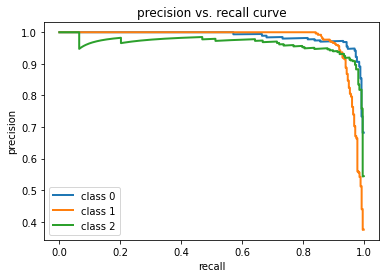

In [75]:
## PR Curve
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        predict_x[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()